## Classifying Flowers using Transfer Learning in Keras

1- Download a small flower dataset (http://download.tensorflow.org/example_images/flower_photos.tgz). This dataset has 5 classes (Daisy, Dandelion, Rese, Sunflower, and Tulip). Images for each class are stored in its own folder.

2- The images have different dimensions. Resize all of them to 150x150.

3- Split images to 75-25% for training and test. Make sure you have the same distribution of flower types between train and test datasets. 

4- Use a VGG16 model (pre-trained on ImageNet)

5- Remove the top layers (fully connected layers)

6- Add your own fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’ activation)

7- First, freeze all layers of VGG16, train (fine-tune) and evaluate the model. You need to pick the right hyper-parameters for your training (try with different ones)

8- Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model

9- Unfreeze all the layers and try again. 

10- Compare the accuracy you got in both cases . Which one is better and why?

## Setup

In [1]:
from keras import optimizers

# if True, will download the pictures
# set to True only the first time you are running this notebook
download_pictures = False
image_w, image_h = 150, 150
batch_size = 20
epochs = 1
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9)

Using TensorFlow backend.


In [2]:
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
from setups import *
from plotting import *
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

In [3]:
# Trainable layers
def pringTrainableLayers(model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.trainable)

In [4]:
def printAccuracy(score):
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

## Data Preparation

In [5]:
import urllib.request
import tarfile

local_filename = 'flower_photos.tgz'

# download the pictures depending on the flag
if download_pictures:
    local_filename, headers = urllib.request.urlretrieve('http://download.tensorflow.org/example_images/flower_photos.tgz',
                                                    filename=local_filename)
    print(headers)
    tar = tarfile.open(local_filename, "r:gz")
    tar.extractall(path=".")
    tar.close()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "flower_photos"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(image_w, image_h),
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='training')

test_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(image_w, image_h),
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='validation')


Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


In [7]:
from tensorflow.keras.preprocessing import image

def printImage(generator):
    for data_batch, labels_batch in train_generator:
        plt.figure(0)
        imgplot = plt.imshow(image.array_to_img(data_batch[0]))
        print('Data batch shape:', data_batch.shape)
        print('Labels batch shape:', labels_batch.shape)
        break

Training data
Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)


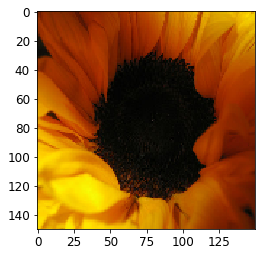

In [8]:
print('Training data')
printImage(train_generator)

Testing data
Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)


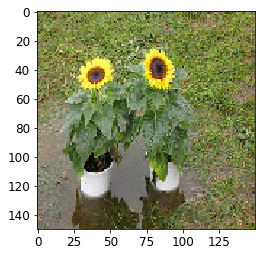

In [9]:
print('Testing data')
printImage(test_generator)


## Model1

In [10]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model1 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
# Freezing all layers
for layer in model1.layers:
    layer.trainable = False
pringTrainableLayers(model1)
model1.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0   

In [11]:
# Adding custom layers to create a new model 
new_model1 = Sequential([
    model1,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Compiling the model
new_model1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# training
new_model1.fit_generator(train_generator,epochs=epochs,verbose=1)
score1 = new_model1.evaluate(test_generator, verbose=1)
printAccuracy(score1)

Epoch 1/1
105/138 [=====================>........] - ETA: 1:21 - loss: 1.5193 - accuracy: 0.3532

## Model2

In [ ]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model2 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
# Freezing the layers until block5
for layer in model2.layers[:15]:
    layer.trainable = False
pringTrainableLayers(model2)
model2.summary()

In [ ]:
# Adding custom layers to create a new model 
new_model2 = Sequential([
    model2,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model2.summary()

In [ ]:
# Compiling the model
new_model2.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# training
new_model2.fit_generator(train_generator,epochs=epochs,verbose=1)
score2 = new_model2.evaluate(test_generator, verbose=1)
printAccuracy(score2)

## Model3

In [ ]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
model3 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
# all layers will be trainable
pringTrainableLayers(model3)
model3.summary()

In [ ]:
# Adding custom layers to create a new model 
new_model3 = Sequential([
    model3,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model3.summary()

In [ ]:
# Compiling the model
new_model3.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# training
new_model3.fit_generator(train_generator,epochs=epochs,verbose=1)
score3 = new_model3.evaluate(test_generator, verbose=1)
printAccuracy(score3)

## Outcome Comparison

In [ ]:
experiments = ["Model 1","Model 2","Model 3"]

test_acc_summary = []

test_acc_summary.append(score1[1])
test_acc_summary.append(score2[1])
test_acc_summary.append(score3[1])

# "bo" is for "blue dot"
plt.plot(experiments, test_acc_summary, 'bo', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Experiments')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
    

The better model is Model 3, because params are all trainable, so it can perform better in this data set.